In [33]:
from sklearn import metrics

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()

from statsmodels.stats.proportion import proportions_ztest

from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler,MinMaxScaler
mms=MinMaxScaler()
sc=StandardScaler()

from sklearn.model_selection import GridSearchCV

import scikitplot as skplt

from xgboost import XGBClassifier

from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score,cross_val_predict

from sklearn.model_selection import KFold

from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report

In [2]:
bank=pd.read_csv('bank-full.csv',delimiter=';')

bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
from statsmodels.stats.anova import anova_lm
from statsmodels.api import OLS

In [4]:
main_df=bank.copy(deep=True)

###### Reducing Skewness of the age

###### Reducing skewness of the balance

In [5]:
main_df['balance'].skew()

8.360308326166326

In [6]:
np.cbrt(main_df['balance']).skew()

-0.07818749236478738

In [7]:
main_df['balance']=np.cbrt(main_df['balance'])

###### Reducing skewness of the duration

In [8]:
main_df['duration'].skew()

3.144318099423456

In [9]:
np.cbrt(main_df['duration']).skew()

0.64014649967056

In [10]:
main_df[main_df['duration']==0]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
6424,53,management,married,primary,no,7.054004,yes,no,unknown,27,may,0,4,-1,0,unknown,no
22937,35,technician,married,secondary,no,17.689106,no,no,cellular,26,aug,0,15,-1,0,unknown,no
36425,31,entrepreneur,married,secondary,no,5.451362,yes,yes,cellular,11,may,0,2,-1,0,unknown,no


In [11]:
main_df['duration']=np.cbrt(main_df['duration'])

In [12]:
main_df['y']=main_df['y'].replace(['no','yes'],[0, 1])

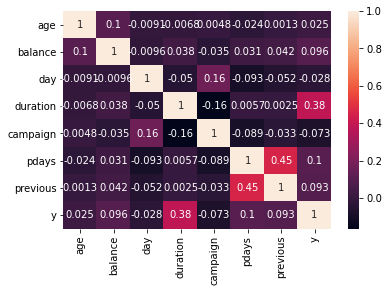

In [13]:
corr_columns = main_df.select_dtypes(include=np.number)
sns.heatmap(corr_columns.corr(),annot=True)

In [14]:
#Due to high Correlation dropping Duration
main_df.drop('duration',axis=1,inplace=True)

#### Conversion

In [15]:
cat_cols = main_df.select_dtypes(include=[
        'object']).columns
df = pd.get_dummies(main_df, columns=cat_cols,drop_first=True)

#standard Scaler for Numerical Variables
scaler = StandardScaler()
num_cols = main_df.select_dtypes(include=np.number).columns
num_cols = num_cols.drop('y')
df[num_cols] = scaler.fit_transform(df[num_cols])

In [16]:
X1 = df.drop(columns=['y'])


y1 =main_df['y']
print(X1.shape)
print(y1.shape)

y1.value_counts().to_frame()

(45211, 41)
(45211,)


,y
0,39922
1,5289


#### Random sampling

In [22]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)

X, y = sampler.fit_resample(X1, y1)
pd.Series(y).value_counts()

0    39922
1    39922
Name: y, dtype: int64

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.67      0.77      0.72      7908
           1       0.74      0.63      0.68      8061

    accuracy                           0.70     15969
   macro avg       0.71      0.70      0.70     15969
weighted avg       0.71      0.70      0.70     15969

0.7011609269532261


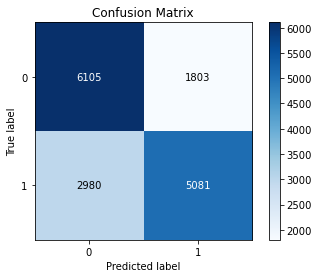

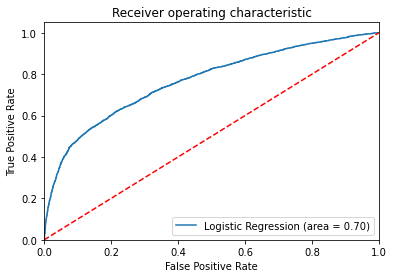

In [24]:
logreg = LogisticRegression()
logreg.fit(X_train,y_train)

y_test_logreg_predict=logreg.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test,y_test_logreg_predict)

print(classification_report(y_test, y_test_logreg_predict))

logit_roc_auc = roc_auc_score(y_test, y_test_logreg_predict)

fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

print(logit_roc_auc)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

#### CROSSVAL SCORE LOGISTIC REGRESSION

In [25]:
cs_logr=cross_val_score(logreg,X_train,y_train,cv=5)
cvp_logr=cross_val_predict(logreg,X_train,y_train,cv=5)
print('scores',cs_logr)
print(classification_report(y_train, cvp_logr))

logr_roc_auc = roc_auc_score(y_train, cvp_logr)
print(logr_roc_auc)

KeyboardInterrupt: 

#### optimum value of Precision Recall

In [ ]:
cvp_logr=cross_val_predict(logreg,X_train,y_train,cv=5,method='decision_function')
logr_precision,logr_recall,logr_thresh=metrics.precision_recall_curve(y_train,cvp_logr)

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(logr_thresh,logr_precision[:-1],label='Precision')
plt.plot(logr_thresh,logr_recall[:-1],label='Recall')
plt.xlabel=('Threshold')
plt.legend()
plt.grid()

#### Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()

In [ ]:
dt.fit(X_train,y_train)
dt_predict=dt.predict(X_test)
print(classification_report(y_test,dt_predict))

rf_roc_auc = roc_auc_score(y_test, dt.predict_proba(X_test)[:,1])
print(rf_roc_auc)

skplt.metrics.plot_confusion_matrix(y_test,dt_predict)

plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, dt.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,marker=',')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.xlabel('false Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

#### Random Forest

#### Cross validation using random forest

In [ ]:
rf=RandomForestClassifier()
cs=cross_val_score(rf,X_train,y_train,cv=5)

print('Scores=',cs)

In [ ]:
cvp=cross_val_predict(rf,X_train,y_train,cv=5)
print(classification_report(y_train, cvp))

rf_roc_auc = roc_auc_score(y_train, cvp)
print(rf_roc_auc)

skplt.metrics.plot_confusion_matrix(y_train,cvp)

#### Creating a Base random forest model

In [ ]:
rf=RandomForestClassifier()

rf.fit(X_train,y_train)
rf_predict=rf.predict(X_test)
print(classification_report(y_test,rf_predict))

rf_roc_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print(rf_roc_auc)

skplt.metrics.plot_confusion_matrix(y_test,rf_predict)

plt.figure()
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,marker=',')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.savefig('Log_ROC')
plt.show()

#### Cross Validation Using KFold

In [ ]:
def classifier(model, X, y):


    kf = KFold(n_splits = 10, shuffle = True, random_state = 4)

    scores = []
    
    
    for train_index,test_index in kf.split(X,y):
        X_train,X_test = X.loc[train_index],X.loc[test_index]
        y_train,y_test = y.loc[train_index],y.loc[test_index]

        # Fit the model on the training data
        model_obj = model.fit(X_train, y_train)
        y_pred = model_obj.predict(X_test)
        # Score the model on the test/validation data
        score = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        scores.append(score)
        mean_score = np.array(scores).mean()
        

    print('Accuracy scores of the model: {:.2f}'.format(mean_score))
    print('\n Classification report of the model')
    print(report)
    print('SCORES',scores)
    print('\n Confusion Matrix of the model')
    print(conf_matrix)

#### Logistic Regression

In [ ]:
logreg=LogisticRegression()
classifier(logreg,X,y)

#### Random Forest

In [ ]:
rf=RandomForestClassifier()

classifier(rf, X, y)

#### XGBOOST

In [38]:
xgb_tuned = XGBClassifier(n_estimators=600,learning_rate=0.1,gamma=.5,max_depth=5,objective='binary:logistic',
                    use_label_encoder=False)

In [39]:
xgb_tuned.fit(X_train,y_train)

[12:29:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=600, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      7908
           1       0.85      0.79      0.82      8061

    accuracy                           0.83     15969
   macro avg       0.83      0.83      0.83     15969
weighted avg       0.83      0.83      0.83     15969

0.907294755273036


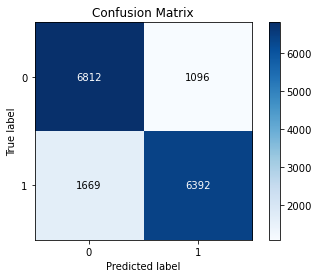

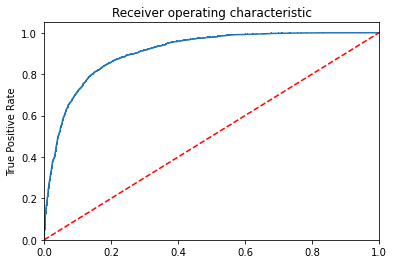

In [40]:
xgb_tuned_predict=xgb_tuned.predict(X_test)
xgb_tuned_proba=xgb_tuned.predict_proba(X_test)
print(classification_report(y_test,xgb_tuned_predict))

skplt.metrics.plot_confusion_matrix(y_test,xgb_tuned_predict)
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_tuned_proba[:,1])
xgb_tuned_score=metrics.roc_auc_score(y_test, xgb_tuned_proba[:,1])
print(xgb_tuned_score)
plt.figure()
plt.plot(fpr, tpr, marker=',')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()